In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt

import ccxt

In [3]:
hyperliquid = ccxt.hyperliquid()
markets = hyperliquid.load_markets()

In [383]:
filters = {
    'swap': True,
    'active': True,
}

volume_limit = 100

perp_markets = []
usd_volume_1d = {}
open_interest = {}
mid_px = {}
for symbol, details in markets.items():
    fits_filters = True
    for k, v in filters.items():
        if details.get(k) != v:
            fits_filters = False
            break
    if fits_filters:
        perp_markets.append({symbol: details})
        usd_volume_1d[symbol.replace('/USDC:USDC', '')] = details['info']['dayNtlVlm']
        open_interest[symbol.replace('/USDC:USDC', '')] = details['info']['openInterest']
        mid_px[symbol.replace('/USDC:USDC', '')] = details['info']['midPx']

liquidity_df = pd.DataFrame({
    'usd_volume_1d': usd_volume_1d,
    'open_interest': open_interest,
    'mid_px': mid_px,  
}).astype(float).sort_values(by='usd_volume_1d', ascending=False)

liquidity_df['open_interest_usd'] = liquidity_df['open_interest'] * liquidity_df['mid_px']
#liquidity_df.sort_values(by='open_interest_usd', ascending=False, inplace=True)
#liquidity_df.head(30) / 1_000_000

volume_thresh = 5 * 1_000_000
open_int_thresh = 10 * 1_000_000

symbols = liquidity_df.query(f'open_interest_usd > {open_int_thresh} and usd_volume_1d > {volume_thresh}').index.tolist()
symbols = [symbol for symbol in symbols if symbol != 'BERA']
liquidity_df.loc[symbols] / 1_000_000

,usd_volume_1d,open_interest,mid_px,open_interest_usd
BTC,3536.965078,0.011927,7.703150e-02,918.776169
ETH,1500.996293,0.394188,1.471950e-03,580.225721
SOL,843.330581,1.922257,1.046900e-04,201.241043
XRP,426.984968,109.131672,1.841350e-06,200.949604
HYPE,179.451650,19.486046,1.097250e-05,213.810637
FARTCOIN,111.173915,89.934689,5.583100e-07,50.211436
SUI,51.000643,15.355294,1.952850e-06,29.986586
ADA,34.324126,48.297030,5.704200e-07,27.549592
kPEPE,32.637025,9281.192176,6.058000e-09,56.225462
DOGE,22.453771,165.900574,1.440650e-07,23.900466


In [84]:
def historical_funding_rate(ticker, start=None, end=None):
    #hyperliquid.fetchFundingRateHistory(symbol=f"{ticker}/USDC:USDC", since=start, limit=500)
    all_funding_rates = []
    while start < end:
        funding_rate_history = hyperliquid.fetchFundingRateHistory(symbol=f"{ticker}/USDC:USDC", since=start, limit=500)
        if not funding_rate_history:
            break
        all_funding_rates.extend(funding_rate_history)
        start = funding_rate_history[-1]['timestamp'] + 1  # Move start to the next timestamp

    result = {entry['timestamp']: entry['fundingRate'] for entry in all_funding_rates}
    return result


def historical_close_volume(ticker, start=None, end=None):
    all_data = []
    while start < end:
        ohlcv_data = hyperliquid.fetch_ohlcv(symbol=f"{ticker}/USDC:USDC", timeframe='1h', since=start, limit=500)
        if not ohlcv_data:
            break
        all_data.extend(ohlcv_data)
        start = ohlcv_data[-1][0] + 1  # Move start to the next timestamp

    result = {entry[0]: {'close': entry[4], 'volume': entry[5]} for entry in all_data}  # Extract timestamp, close price, and volume
    return result


def get_historical_data(ticker, start, end):
    funding_rate = historical_funding_rate(ticker, start, end)
    close_volume = historical_close_volume(ticker, start, end)

    df = pd.DataFrame({
        'funding': funding_rate,
        'close': {timestamp: data['close'] for timestamp, data in close_volume.items()},
        'volume': {timestamp: data['volume'] for timestamp, data in close_volume.items()},
    }).sort_index()
    df.index = pd.to_datetime(df.index, unit='ms', utc=True)
    df = df.resample('h').last()    
    return df

In [90]:
start = int((datetime.now() - timedelta(days=90)).timestamp() * 1000)
end = int(datetime.now().timestamp() * 1000)

bera_df = get_historical_data('BERA', start, end)
bera_df.head()

,funding,close,volume
2025-02-06 13:00:00+00:00,NaN,12.3810,5492924.8
2025-02-06 14:00:00+00:00,-0.001629,11.2840,6724740.2
2025-02-06 15:00:00+00:00,-0.006808,8.5597,8868091.2
2025-02-06 16:00:00+00:00,-0.007256,8.8401,5056336.0
2025-02-06 17:00:00+00:00,-0.004617,8.9673,2233687.6


In [129]:
data = {}

start = int(bera_df.index[0].timestamp() * 1000)
for symbol in tqdm(symbols):
    data[symbol] = get_historical_data(symbol, start, end)

100%|██████████| 19/19 [01:53<00:00,  5.99s/it]


In [132]:
funding_df = pd.DataFrame({k: df['funding'] for k, df in data.items()})
price_df = pd.DataFrame({k: df['close'] for k, df in data.items()})
volume_df = pd.DataFrame({k: df['volume'] for k, df in data.items()})
notional_df = price_df * volume_df

funding_df.head()
price_df.head()
notional_df.head()

,BTC,ETH,SOL,XRP,HYPE,FARTCOIN,SUI,ADA,kPEPE,DOGE,AVAX,ENA,TRUMP,AAVE,BNB,LINK,LTC,TAO,MKR
2025-02-06 13:00:00+00:00,8.714670e+07,6.265296e+07,1.009524e+07,3.834095e+06,1.314590e+07,3.080540e+06,8.740591e+06,200880.66455,7.577378e+05,5.799611e+05,270934.73035,9.226796e+05,2.896725e+06,2.373924e+05,767048.45040,3.203976e+05,393317.7800,775950.14868,10441.878125
2025-02-06 14:00:00+00:00,1.425022e+08,1.422917e+08,1.718506e+07,6.881587e+06,1.061042e+07,6.955825e+06,3.591087e+06,345844.72287,6.464409e+06,1.028652e+06,338711.48428,3.940922e+06,4.928216e+06,1.158075e+06,460528.80808,6.876619e+05,401348.0364,320241.57891,234122.852050
2025-02-06 15:00:00+00:00,1.354810e+08,2.006654e+08,4.503141e+07,1.211418e+07,2.111475e+07,5.102764e+06,1.173187e+07,806027.50644,5.653274e+06,2.611270e+06,896032.82052,2.844144e+06,7.340078e+06,2.452424e+06,206498.60055,1.879289e+06,259534.7992,605734.28600,293091.952104
2025-02-06 16:00:00+00:00,1.173435e+08,1.129502e+08,3.684929e+07,5.632255e+06,1.126136e+07,8.612734e+06,6.975594e+06,129315.49974,7.403519e+06,2.241826e+06,909347.55496,1.122675e+06,5.281595e+06,2.998520e+06,347939.60550,8.715841e+05,370778.8944,405170.08800,87537.730000
2025-02-06 17:00:00+00:00,1.099661e+08,3.712595e+07,2.937400e+07,1.117412e+07,1.045818e+07,9.268218e+06,6.643098e+06,248277.40608,2.872364e+06,3.136068e+06,544602.73816,1.461901e+06,4.538053e+06,5.686267e+05,81444.33764,3.159378e+05,99216.8892,323874.03360,298387.681632


In [341]:
start = '2025-02-15 00:00:00+00:00'

bera_returns = bera_df['close'].loc[start:].pct_change().dropna()
asset_returns = price_df.loc[start:].pct_change().dropna()
bera_returns, asset_returns = bera_returns.align(asset_returns, join='inner', axis=0)

mean_returns = asset_returns.mean()
cov_matrix = asset_returns.cov()

correlations = asset_returns.corrwith(bera_returns)
correlations.sort_values(ascending=False)

DOGE        0.550543
LINK        0.550217
ETH         0.549435
SUI         0.535821
AAVE        0.533349
AVAX        0.532142
kPEPE       0.525043
BTC         0.512024
TAO         0.508277
BNB         0.505522
SOL         0.503497
XRP         0.469155
LTC         0.468738
ENA         0.461535
TRUMP       0.460692
FARTCOIN    0.433193
HYPE        0.426098
MKR         0.401232
ADA         0.351071
dtype: float64

In [331]:
import cvxpy as cp
import numpy as np

# Number of assets
num_assets = asset_returns.shape[1]

# Variables
weights = cp.Variable(num_assets)

# Portfolio return
portfolio_return = asset_returns.values @ weights

# Tracking error
tracking_error = cp.norm(portfolio_return - bera_returns, 'fro')

# Objective function: Minimize tracking error
objective = cp.Minimize(tracking_error)

# Constraints
constraints = [
    cp.sum(weights) == 1,       # Weights sum to 1
    weights >= 0,               # No short selling
    weights <= 0.5              # Example: No more than 20% in any asset
]

# Problem definition
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Optimal weights
optimal_weights = weights.value

In [332]:
portfolio_returns = asset_returns.dot(optimal_weights)
# Align the indices of portfolio_returns and bera_returns
portfolio_returns, bera_returns = portfolio_returns.align(bera_returns, join='inner')
# Calculate the differences between portfolio and benchmark returns
return_differences = portfolio_returns - bera_returns

# Compute the tracking error
tracking_error = np.std(return_differences)
bera_returns.corr(portfolio_returns)

np.float64(0.6037413441885101)

<Axes: >

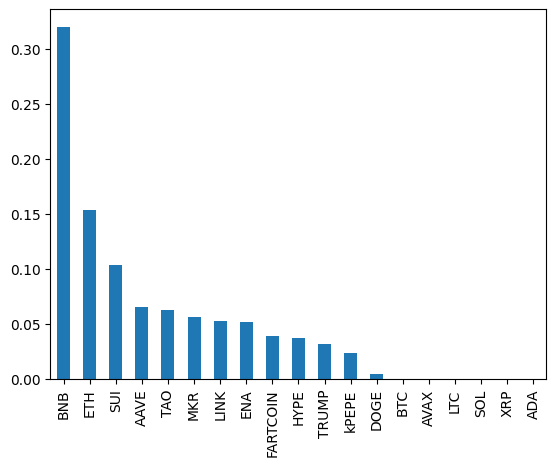

In [333]:
asset_names = asset_returns.columns
portfolio_weights = pd.Series(data=optimal_weights, index=asset_names, name='Weight')
portfolio_weights.sort_values(ascending=False, inplace=True)
portfolio_weights.plot.bar()

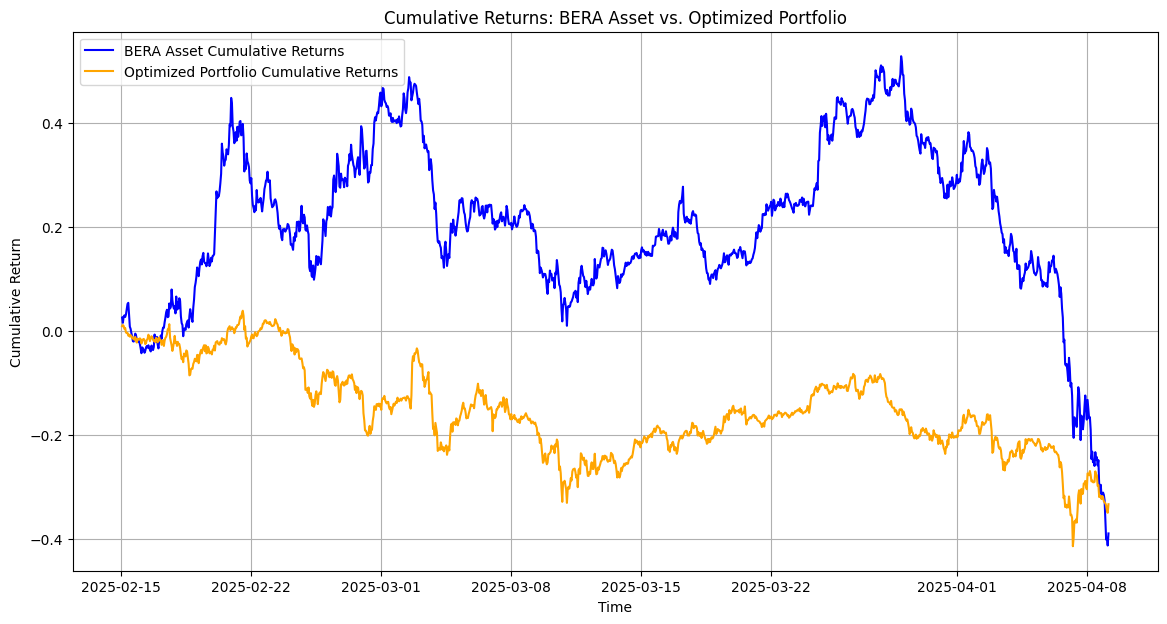

In [342]:
# Calculate cumulative returns
cumulative_bera_returns = (1 + bera_returns).cumprod() - 1
cumulative_portfolio_returns = (1 + portfolio_returns).cumprod() - 1

cumulative_bera_returns = bera_returns.cumsum()
cumulative_portfolio_returns = portfolio_returns.cumsum()

plt.figure(figsize=(14, 7))
plt.plot(cumulative_bera_returns, label='BERA Asset Cumulative Returns', color='blue')
plt.plot(cumulative_portfolio_returns, label='Optimized Portfolio Cumulative Returns', color='orange')
plt.title('Cumulative Returns: BERA Asset vs. Optimized Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

np.float64(-971678.9159709873)

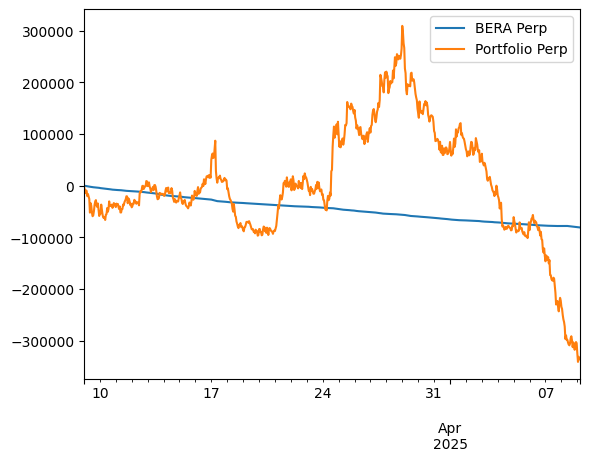

In [349]:
start = '2025-03-09 00:00:00+00:00'

position_size = 1_000_000
position_size_bera = position_size/ bera_df['close'].loc[start]

bera_spot_pnl = (bera_df['close'].loc[start:] - bera_df['close'].loc[start]) * position_size_bera
bera_perp_pnl = -1 * (bera_df['close'].loc[start:] - bera_df['close'].loc[start]) * position_size_bera
bera_perp_notional = position_size + bera_perp_pnl
bera_funding_costs = bera_df['funding'].loc[start:] * (position_size + bera_perp_pnl)

portfolio_position_sizes = position_size * portfolio_weights[price_df.columns]
portfolio_sizes_quote = portfolio_position_sizes / price_df[portfolio_position_sizes.index].loc[start]

portfolio_perp_pnl = (-1 * (price_df.loc[start:] - price_df.loc[start]) * portfolio_sizes_quote)
portfolio_funding_costs = funding_df.loc[start:] * (portfolio_position_sizes + portfolio_perp_pnl)

pd.DataFrame({
    'BERA Perp': bera_spot_pnl + bera_perp_pnl + bera_funding_costs.fillna(0).cumsum(),
    'Portfolio Perp': (bera_spot_pnl + portfolio_perp_pnl.sum(1) + portfolio_funding_costs.sum(1).cumsum()).dropna(),
}).plot()

bera_funding_costs.sum() * 12

In [355]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Calculate returns
returns_df = price_df.pct_change().dropna()

# Standardize the returns
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns_df)

# Apply PCA
pca = PCA()
pca.fit(returns_scaled)

# Obtain principal components
principal_components = pca.transform(returns_scaled)

# Create a DataFrame for principal components
pc_df = pd.DataFrame(data=principal_components, index=returns_df.index)

# Correlate the first principal component with the target asset's returns
target_returns = bera_df['close'].pct_change().dropna()
correlation_with_pc1 = pc_df.iloc[:, 0].corr(target_returns)
print(f"Correlation with PC1: {correlation_with_pc1}")

Correlation with PC1: 0.4916823293014173


In [356]:
# Get loadings (eigenvectors)
loadings = pca.components_

# Focus on the first principal component
pc1_loadings = loadings[0]

# Create a DataFrame for asset loadings
loadings_df = pd.DataFrame(data=pc1_loadings, index=returns_df.columns, columns=['PC1 Loading'])

# Normalize loadings to sum to 1 for weight adjustment
loadings_df['Adjusted Weight'] = loadings_df['PC1 Loading'] / loadings_df['PC1 Loading'].sum()

# Display adjusted weights
print(loadings_df)

          PC1 Loading  Adjusted Weight
BTC          0.242140         0.055869
ETH          0.251335         0.057991
SOL          0.247725         0.057158
XRP          0.240971         0.055599
HYPE         0.193992         0.044760
FARTCOIN     0.191699         0.044231
SUI          0.243903         0.056276
ADA          0.220381         0.050849
kPEPE        0.244205         0.056346
DOGE         0.259410         0.059854
AVAX         0.252323         0.058219
ENA          0.210566         0.048584
TRUMP        0.204135         0.047100
AAVE         0.244711         0.056462
BNB          0.205554         0.047428
LINK         0.256928         0.059281
LTC          0.223807         0.051639
TAO          0.226380         0.052233
MKR          0.173885         0.040121


In [359]:
# Apply adjusted weights to the asset basket
optimized_weights = loadings_df['Adjusted Weight']

# Ensure no negative weights (if short selling is not allowed)
#optimized_weights = optimized_weights.clip(lower=0)

# Normalize weights to sum to 1
optimized_weights /= optimized_weights.sum()

print("Optimized Portfolio Weights:")
print(optimized_weights)

Optimized Portfolio Weights:
BTC         0.055869
ETH         0.057991
SOL         0.057158
XRP         0.055599
HYPE        0.044760
FARTCOIN    0.044231
SUI         0.056276
ADA         0.050849
kPEPE       0.056346
DOGE        0.059854
AVAX        0.058219
ENA         0.048584
TRUMP       0.047100
AAVE        0.056462
BNB         0.047428
LINK        0.059281
LTC         0.051639
TAO         0.052233
MKR         0.040121
Name: Adjusted Weight, dtype: float64


In [360]:
# Calculate the portfolio returns with the new weights
optimized_portfolio_returns = (returns_df * optimized_weights).sum(axis=1)

# Correlate the optimized portfolio returns with the target asset's returns
optimized_correlation = optimized_portfolio_returns.corr(target_returns)
print(f"Optimized Correlation with Target Asset: {optimized_correlation}")

Optimized Correlation with Target Asset: 0.4925089284352254


In [378]:
from sklearn.decomposition import PCA

# Step 1: Run PCA on asset returns
pca = PCA(n_components=5)  # you can tune this
pca_factors = pca.fit_transform(asset_returns)

# Step 2: Reconstruct returns using top components only
cleaned_returns = pca.inverse_transform(pca_factors)
cleaned_returns_df = pd.DataFrame(cleaned_returns, index=asset_returns.index, columns=asset_returns.columns)

# Align indices
bera_returns, asset_returns = bera_returns.align(cleaned_returns_df, join='inner', axis=0)

# Convert to numpy
R = asset_returns.values
r_bera = bera_returns.values

n_assets = R.shape[1]
w = cp.Variable(n_assets)

# Predicted portfolio return
r_portfolio = R @ w

# Objective: Minimize squared tracking error
objective = cp.Minimize(cp.sum_squares(r_portfolio - r_bera))

# Constraints: weights sum to 1, and optional bounds
constraints = [cp.sum(w) == 1, w >= 0]

# Solve
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract weights
optimal_weights = pd.Series(w.value, index=asset_returns.columns)
optimal_weights

BTC         0.136338
ETH         0.099850
SOL         0.043164
XRP         0.027730
HYPE        0.050671
FARTCOIN    0.007206
SUI         0.023635
ADA         0.028212
kPEPE       0.018135
DOGE        0.054646
AVAX        0.040108
ENA         0.023981
TRUMP       0.052575
AAVE        0.041354
BNB         0.150310
LINK        0.037736
LTC         0.090088
TAO         0.027451
MKR         0.046810
dtype: float64

Optimized correlation: 0.57892


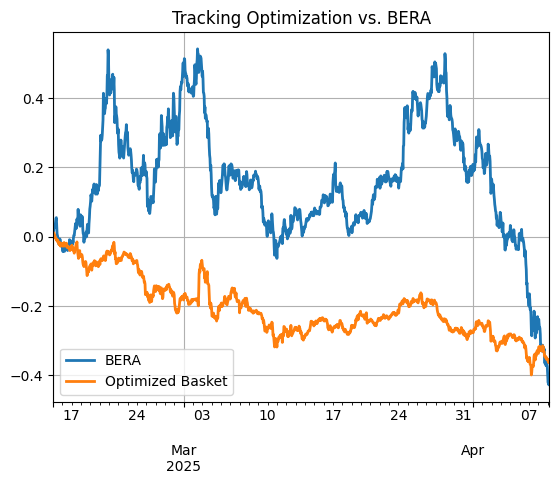

In [379]:
# Recreate portfolio returns
tracked_returns = asset_returns.dot(optimal_weights)

# Correlation with BERA
correlation = tracked_returns.corr(bera_returns)
print(f"Optimized correlation: {correlation:.5f}")

# Optional: Plot cumulative returns
((1 + bera_returns).cumprod() - 1).plot(label="BERA", linewidth=2)
((1 + tracked_returns).cumprod() - 1).plot(label="Optimized Basket", linewidth=2)
plt.title("Tracking Optimization vs. BERA")
plt.legend()
plt.grid(True)
plt.show()